# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [9]:
%load_ext autoreload
%autoreload 2

import pathlib
import logging

import tensorflow as tf
import keras

from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml import dataset
from usl_models.flood_ml import visualizer
from usl_models.flood_ml import eval


logging.getLogger().setLevel(logging.INFO)

sim_names = ["Manhattan-config_v1/Rainfall_Data_1.txt"]
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
# @title Download dataset (only needs to be run the first time)
# dataset.download_dataset(sim_names, dataset_splits=["train"], output_path=filecache_dir)

In [14]:
# Load dataset and train model.
train_dataset = dataset.load_dataset_windowed_cached(
    filecache_dir=filecache_dir,
    sim_names=sim_names,
    batch_size=4,
    dataset_split="train",
)
model = FloodModel(
    FloodModel.Params(
        lstm_units=32,
        lstm_kernel_size=3,
        lstm_dropout=0.2,
        lstm_recurrent_dropout=0.2,
        m_rainfall=6,
        n_flood_maps=5,
        num_features=22,
        optimizer=keras.optimizers.Adam(
            learning_rate=1e-3, gradient_accumulation_steps=16
        ),
    )
)
model.fit(train_dataset, epochs=1)

/opt/conda/envs/climateiq-k3/lib/python3.11/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'flood_conv_lstm_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


185/185 ━━━━━━━━━━━━━━━━━━━━ 66s 349ms/step - loss: 0.0024 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0975


/opt/conda/envs/climateiq-k3/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-12-28 06:57:24.858071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# Test calling the model on some data.
inputs, labels_ = next(iter(train_dataset))
prediction = model.call(inputs)
prediction.shape

TensorShape([4, 1000, 1000, 1])

In [16]:
# Test calling the model for n predictions
full_dataset = dataset.load_dataset_cached(
    filecache_dir=filecache_dir, sim_names=sim_names, batch_size=4
)
inputs, labels, metadata_ = next(iter(full_dataset))
predictions = model.call_n(inputs, n=19)
predictions.shape, labels.shape

(TensorShape([4, 19, 1000, 1000]), TensorShape([4, 19, 1000, 1000]))

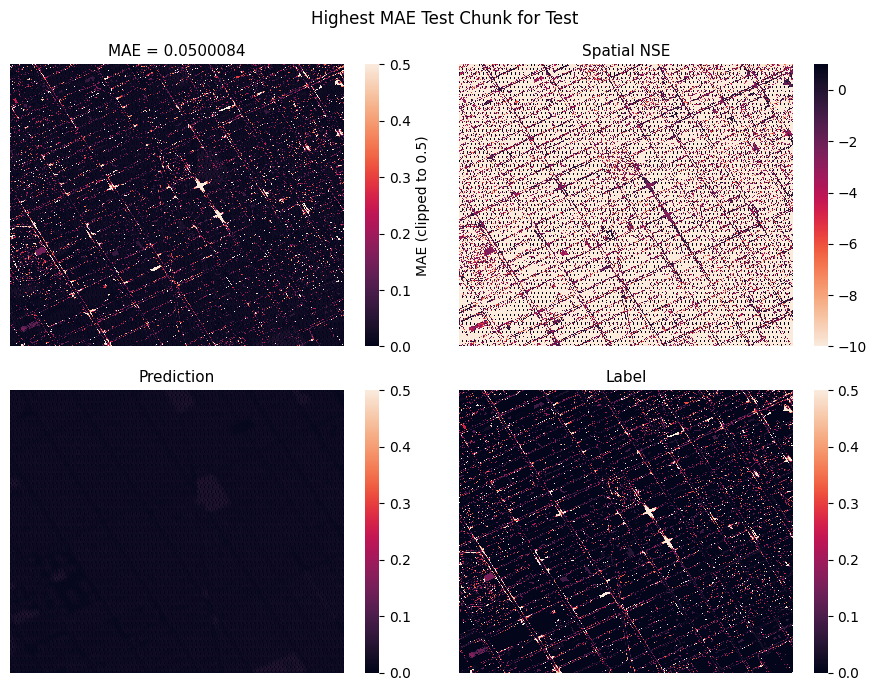

In [17]:
spatial_maes = []
temporal_mae, temporal_rmse = [], []
max_mae = 0.0
max_spatial_mae = None
highest_error_nse = None
highest_error_pred = None
highest_error_label = None

for prediction, label in zip(tf.unstack(predictions), tf.unstack(labels)):
    max_pred = tf.reduce_max(prediction, axis=0)
    max_label = tf.reduce_max(label, axis=0)
    spatial_mae = eval.spatial_mae(max_pred, max_label)

    temporal_mae.append(eval.temporal_mae(prediction, label))
    temporal_rmse.append(eval.temporal_rmse(prediction, label))

    spatial_maes.append(spatial_mae)

    mae = tf.reduce_mean(spatial_mae)
    if mae > max_mae:
        max_mae = mae
        max_spatial_mae = spatial_mae
        max_mae_nse = eval.spatial_nse(prediction, label)
        max_mae_pred = max_pred
        max_mae_label = max_label

num_test_examples = len(spatial_maes)
overall_mae = tf.reduce_mean(tf.stack(spatial_maes))
temporal_mae = tf.reduce_mean(tf.stack(temporal_mae), axis=0)
temporal_rmse = tf.reduce_mean(tf.stack(temporal_rmse), axis=0)

visualizer.plot_maps(
    "Test",
    spatial_mae=max_spatial_mae,
    nse=max_mae_nse,
    pred=max_mae_pred,
    label=max_mae_label,
)